In [2]:
import numpy as np
import pickle
import tensorflow as tf

In [3]:
tf.__version__

'1.14.0'

In [295]:
with open('x_raw.pickle', 'rb') as handle:
    x_raw = pickle.load(handle)
with open('label.pickle', 'rb') as handle:
    label = pickle.load(handle)

In [296]:
len(x_raw)

126

In [297]:
len(label)

126

### Preprocessing option 1: finding the min # of samples and downsampling

In [298]:
min_sample_size = min([m.shape[0] for m in x_raw])
print(min_sample_size)

78


In [299]:
x_downsampled = []
for elem in x_raw:
    # randomly sampling the indices for each matrix
    random_idx = np.random.randint(0, elem.shape[0], min_sample_size)
    # sort the indices to match the timestamps
    random_idx.sort()
    # downsampling
    x_downsampled.append(elem[random_idx, :])
x_downsampled = np.array(x_downsampled)

In [300]:
x_downsampled.shape

(126, 78, 3)

In [301]:
sample_size = x_downsampled.shape[0]

In [303]:
num_classes = 10

#### shuffling and splitting data

In [304]:
X = np.array(x_downsampled).reshape(sample_size, -1)
X.shape

(126, 234)

In [305]:
y = np.eye(num_classes)[np.array(label)]

In [306]:
y.shape

(126, 10)

In [307]:
data_tmp = np.hstack([X, y])
data_tmp.shape

(126, 244)

In [373]:
# shuffle the data
np.random.seed(11)
np.random.shuffle(data_tmp)
data_tmp.shape

(126, 244)

In [374]:
data_tmp[0:5, -10:-1]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [375]:
X = data_tmp[:, :-10]
y = data_tmp[:, -10:]
print(X.shape, y.shape)

(126, 234) (126, 10)


In [376]:
train_idx = 80
X_train, X_test = X[:train_idx, :], X[train_idx:, :]
y_train, y_test = y[:train_idx, :], y[train_idx:, :]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(80, 234) (46, 234)
(80, 10) (46, 10)


#### Random Forest

In [377]:
from sklearn.ensemble import RandomForestClassifier

In [378]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [379]:
rf.score(X_train, y_train)

0.95

In [380]:
rf.score(X_test, y_test)

0.2391304347826087

#### Logistic Regression

In [381]:
from sklearn.linear_model import LogisticRegression

In [382]:
lg = LogisticRegression(penalty='l2', C=1.0, solver='newton-cg', multi_class='multinomial')
lg.fit(X_train, np.dot(y_train, range(num_classes)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [383]:
lg.score(X_train, np.dot(y_train, range(num_classes)))

1.0

In [384]:
lg.score(X_test, np.dot(y_test, range(num_classes)))

0.7391304347826086

In [385]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [386]:
cm = confusion_matrix(np.dot(y_test, range(num_classes)), 
                      lg.predict(X_test))

In [387]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [388]:
cm

array([[3, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 2, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 7, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 3, 0],
       [0, 2, 0, 0, 1, 0, 0, 1, 0, 2]])

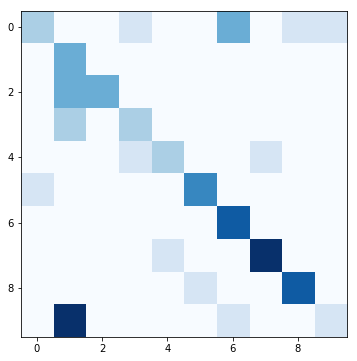

In [372]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.show()

#### SVM

In [288]:
from sklearn.svm import SVC

In [290]:
svc = SVC(C=1.0, kernel='poly', degree=3, decision_function_shape='ovo')
svc.fit(X_train, np.dot(y_train, range(3)))

/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [292]:
svc.score(X_train, np.dot(y_train, range(3)))

1.0

In [294]:
svc.score(X_test, np.dot(y_test, range(3)))

0.8

#### DNN

In [141]:
tf.reset_default_graph()

In [142]:
input_shape =  X_train.shape[1]
fc1_shape = 64
fc2_shape = 32

In [143]:
x = tf.placeholder(tf.float32, shape=[None, input_shape], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_')
keep_proba = tf.placeholder(tf.float32, shape=())

In [144]:
with tf.variable_scope("fc1") as scope:
    weights = tf.get_variable(name="weights", shape=[input_shape, fc1_shape], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    bias = tf.get_variable(name="bias", shape=[fc1_shape], dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    fc = tf.matmul(x, weights, name="matmul")
    pre_activation = tf.add(fc, bias)
    fc1 = tf.nn.relu(pre_activation, name="relu")
    dp1 = tf.nn.dropout(fc1, keep_prob=keep_proba)

print(weights)
print(dp1)

<tf.Variable 'fc1/weights:0' shape=(234, 64) dtype=float32_ref>
Tensor("fc1/dropout/mul_1:0", shape=(?, 64), dtype=float32)


In [145]:
with tf.variable_scope("fc2") as scope:
    weights = tf.get_variable(name="weights", shape=[fc1_shape, fc2_shape], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    bias = tf.get_variable(name="bias", shape=[fc2_shape], dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    fc = tf.matmul(dp1, weights, name="matmul")
    pre_activation = tf.add(fc, bias)
    fc2 = tf.nn.relu(pre_activation, name="relu")
    dp2 = tf.nn.dropout(fc2, keep_prob=keep_proba)

print(weights)
print(fc2)

<tf.Variable 'fc2/weights:0' shape=(64, 32) dtype=float32_ref>
Tensor("fc2/relu:0", shape=(?, 32), dtype=float32)


In [146]:
with tf.variable_scope("fc3") as scope:
    weights = tf.get_variable(name="weights", shape=[fc2_shape, num_classes], dtype=tf.float32,
                              initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    bias = tf.get_variable(name="bias", shape=[num_classes], dtype=tf.float32,
                           initializer=tf.contrib.layers.xavier_initializer(), trainable=True)
    fc = tf.matmul(dp2, weights, name="matmul")
    logits = tf.add(fc, bias, name="logits")
    y_proba = tf.nn.softmax(logits, name="y_proba")
    y_pred = tf.argmax(logits, axis=1, name="y_pred")

print(weights)
print(logits)

<tf.Variable 'fc3/weights:0' shape=(32, 10) dtype=float32_ref>
Tensor("fc3/logits:0", shape=(?, 10), dtype=float32)


In [147]:
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits, name="cross_entropy")
    loss = tf.reduce_mean(cross_entropy, name="cross_entropy_loss")
    #train_step = tf.train.RMSPropOptimizer(learning_rate=1e-4).minimize(loss, name="train_step")
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss, name="train_step")
print(cross_entropy)
print(loss)

Tensor("loss/cross_entropy/Reshape_2:0", shape=(?,), dtype=float32)
Tensor("loss/cross_entropy_loss:0", shape=(), dtype=float32)


In [148]:
with tf.name_scope("eval"):
    correct = tf.equal(y_pred, tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
print(correct)
print(accuracy)

Tensor("eval/Equal:0", shape=(?,), dtype=bool)
Tensor("eval/accuracy:0", shape=(), dtype=float32)


#### training

In [149]:
sess = tf.Session()
# Initialize the variables (i.e. assign their default value)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [150]:
train_loss, train_accuracy = sess.run([loss, accuracy], 
                                      feed_dict={x: X_train, 
                                                 y_: y_train,
                                                 keep_proba: 1.0})
print('Epoch %d, training loss: %g, training accuracy: %g' % (0, train_loss, train_accuracy))
val_loss, val_accuracy = sess.run([loss, accuracy], 
                                  feed_dict={x: X_test,
                                             y_: y_test,
                                             keep_proba: 1.0})
print('Epoch %d, validation loss: %g, validation accuracy %g' % (0, val_loss, val_accuracy))
#results["init_loss"].append(val_loss)
#results["init_acc"].append(val_accuracy)
max_accuracy = val_accuracy

Epoch 0, training loss: 8.80593, training accuracy: 0.15
Epoch 0, validation loss: 6.92341, validation accuracy 0.173913


In [152]:
batch_size = 10
n_epochs = 50
n_batches = int(X_train.shape[0] / batch_size)
display_step = 5
max_accuracy = 0

save_ckps_dir = "./chkps_mnist_air/dnn2"

In [171]:
for i in range(n_epochs):
    batch_start = 0
    batch_end = batch_size
    for j in range(n_batches):
        batch_images, batch_labels = X_train[batch_start:batch_end, :], y_train[batch_start:batch_end, :]
        sess.run(train_step, feed_dict={x: batch_images, 
                                        y_: batch_labels,
                                        keep_proba: 0.8})
        batch_start += batch_size
        batch_end += batch_size
        
    train_loss, train_accuracy = sess.run([loss, accuracy], 
                                          feed_dict={x: X_train, 
                                                     y_: y_train,
                                                     keep_proba: 1.0})
    #results["train_loss"].append(train_loss)
    #results["train_acc"].append(train_accuracy)

    val_loss, val_accuracy = sess.run([loss, accuracy], 
                                      feed_dict={x: X_test,
                                                 y_: y_test, 
                                                 keep_proba: 1.0})
    #results["val_loss"].append(val_loss)
    #results["val_acc"].append(val_accuracy)
    
    if val_accuracy > max_accuracy:
        print("Save the current model!")
        max_accuracy = val_accuracy
        saver.save(sess, save_ckps_dir)
    
    if (i+1) % display_step == 0:
        print('Epoch %d, training loss: %g, training accuracy: %g' % (i, train_loss, train_accuracy))
        print('Epoch %d, validation loss: %g, validation accuracy %g' % (i, val_loss, val_accuracy))

Epoch 4, training loss: 0.00494452, training accuracy: 1
Epoch 4, validation loss: 1.23186, validation accuracy 0.673913
Epoch 9, training loss: 0.00456187, training accuracy: 1
Epoch 9, validation loss: 1.2031, validation accuracy 0.630435
Epoch 14, training loss: 0.00446191, training accuracy: 1
Epoch 14, validation loss: 1.22853, validation accuracy 0.630435
Epoch 19, training loss: 0.00418288, training accuracy: 1
Epoch 19, validation loss: 1.24122, validation accuracy 0.630435
Epoch 24, training loss: 0.00400958, training accuracy: 1
Epoch 24, validation loss: 1.23749, validation accuracy 0.652174
Epoch 29, training loss: 0.00408561, training accuracy: 1
Epoch 29, validation loss: 1.21842, validation accuracy 0.630435
Epoch 34, training loss: 0.00387001, training accuracy: 1
Epoch 34, validation loss: 1.21526, validation accuracy 0.652174
Epoch 39, training loss: 0.0040474, training accuracy: 1
Epoch 39, validation loss: 1.24065, validation accuracy 0.630435
Epoch 44, training los

In [159]:
from tensorflow.saved_model import signature_def_utils, signature_constants, tag_constants
from tensorflow.saved_model import utils as save_model_utils

In [45]:
savemodel_file_path = "./savedmodel/mnist_air_dnn"

In [48]:
x_op = sess.graph.get_operation_by_name('x')
x_node = x_op.outputs[0]
pred_op = sess.graph.get_operation_by_name('fc3/y_proba')
pred = pred_op.outputs[0]

In [52]:
prediction_signature = signature_def_utils.build_signature_def(
    inputs={"input": save_model_utils.build_tensor_info(x)},
    outputs={"output":save_model_utils.build_tensor_info(pred)},
    method_name=signature_constants.PREDICT_METHOD_NAME)

W1114 17:29:00.628089 4668990912 deprecation.py:323] From <ipython-input-52-9cbaaab7d65e>:2: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [53]:
builder = tf.saved_model.builder.SavedModelBuilder(savemodel_file_path)
builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING], 
                                     signature_def_map={"predict": prediction_signature})
builder.save()

b'./savedmodel/mnist_air_dnn/saved_model.pb'

In [73]:
sess.close()